In [1]:
import sys
sys.path.append('../')
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
%matplotlib inline
import backtrader as bt

In [2]:
from datafeed.dataloader import CSVDataloader
df = CSVDataloader.get_backtrader_df('000300.SH')
df.dropna()

,open,high,low,close,volume,openinterest
date,,,,,,
2010-01-04,3592.4680,3597.7480,3535.2290,3535.2290,66101080.0,0
2010-01-05,3545.1860,3577.5260,3497.6610,3564.0380,85809641.0,0
2010-01-06,3558.7000,3588.8320,3541.1730,3541.7270,78473125.0,0
2010-01-07,3543.1600,3558.5560,3452.7690,3471.4560,80350037.0,0
2010-01-08,3456.9080,3482.0830,3426.6980,3480.1300,60790253.0,0
...,...,...,...,...,...,...
2024-06-12,3539.0947,3551.1706,3531.5657,3544.1225,122813729.0,0
2024-06-13,3548.2162,3551.0771,3520.1802,3526.1306,123245462.0,0
2024-06-14,3514.7998,3547.1473,3503.5233,3541.5331,171516942.0,0


In [7]:
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.order_target_percent(self.data,0.99)  # enter long
                #self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

In [8]:


cerebro = bt.Cerebro()
cerebro.broker.setcash(100*10000.0)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)


print('初始资金: %.2f' % cerebro.broker.getvalue())
cerebro.addstrategy(SmaCross)
strats = cerebro.run()

print('期末资金: %.2f' % cerebro.broker.getvalue())

初始资金: 1000000.00
期末资金: 1543539.72


In [20]:
strat0 = strats[0]
pyfolio = strat0.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio.get_pf_items()
transactions

,amount,price,sid,symbol,value
date,,,,,
2010-03-08 00:00:00+00:00,303,3268.3970,0,,-9.903243e+05
2010-04-26 00:00:00+00:00,-303,3195.4570,0,,9.682235e+05
2010-07-23 00:00:00+00:00,348,2787.5210,0,,-9.700573e+05
2010-09-28 00:00:00+00:00,-348,2900.5360,0,,1.009387e+06
2010-10-12 00:00:00+00:00,321,3121.6360,0,,-1.002045e+06
...,...,...,...,...,...
2023-11-28 00:00:00+00:00,-424,3510.6554,0,,1.488518e+06
2024-02-22 00:00:00+00:00,432,3450.3518,0,,-1.490552e+06
2024-04-09 00:00:00+00:00,-432,3533.3849,0,,1.526422e+06


In [18]:
import quantstats as qs
qs.reports.metrics(returns)

D:\quant\lab\venv\lib\site-packages\quantstats\stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    Strategy
------------------  ----------
Start Period        2010-01-04
End Period          2024-06-18
Risk-Free Rate      0.0%
Time in Market      53.0%

Cumulative Return   54.35%
CAGR﹪              2.09%

Sharpe              0.29
Prob. Sharpe Ratio  85.68%
Sortino             0.4
Sortino/√2          0.28
Omega               1.08

Max Drawdown        -35.15%
Longest DD Days     3298

Gain/Pain Ratio     0.08
Gain/Pain (1M)      0.3

Payoff Ratio        0.96
Profit Factor       1.08
Common Sense Ratio  1.19
CPC Index           0.55
Tail Ratio          1.11
Outlier Win Ratio   9.06
Outlier Loss Ratio  3.23

MTD                 0.84%
3M                  -1.25%
6M                  2.12%
YTD                 2.12%
1Y                  -5.33%
3Y (ann.)           -0.73%
5Y (ann.)           1.26%
10Y (ann.)          4.17%
All-time (ann.)     2.09%

Avg. Drawdown       -5.57%
Avg. Drawdown Days  233
Recovery Factor     1.65
Ulcer Index         0.18
Serenity Index      0.1


D:\quant\lab\venv\lib\site-packages\quantstats\stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    Strategy
------------------  ----------
Start Period        2010-01-04
End Period          2024-06-18
Risk-Free Rate      0.0%
Time in Market      53.0%

Cumulative Return   54.35%
CAGR﹪              2.09%

Sharpe              0.29
Prob. Sharpe Ratio  85.68%
Sortino             0.4
Sortino/√2          0.28
Omega               1.08

Max Drawdown        -35.15%
Longest DD Days     3298

Gain/Pain Ratio     0.08
Gain/Pain (1M)      0.3

Payoff Ratio        0.96
Profit Factor       1.08
Common Sense Ratio  1.19
CPC Index           0.55
Tail Ratio          1.11
Outlier Win Ratio   9.06
Outlier Loss Ratio  3.23

MTD                 0.84%
3M                  -1.25%
6M                  2.12%
YTD                 2.12%
1Y                  -5.33%
3Y (ann.)           -0.73%
5Y (ann.)           1.26%
10Y (ann.)          4.17%
All-time (ann.)     2.09%

Avg. Drawdown       -5.57%
Avg. Drawdown Days  233
Recovery Factor     1.65
Ulcer Index         0.18
Serenity Index      0.1


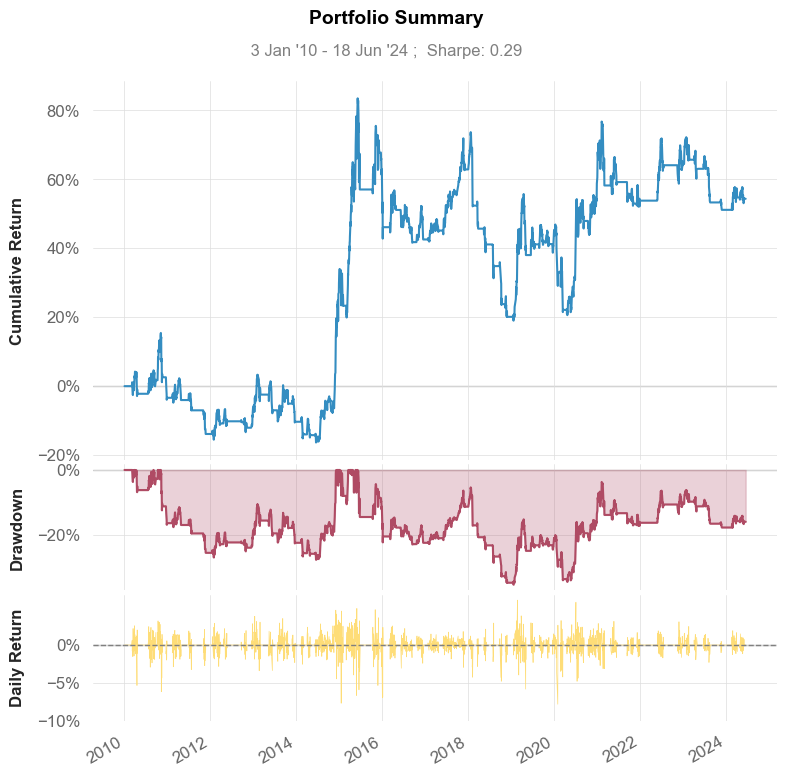

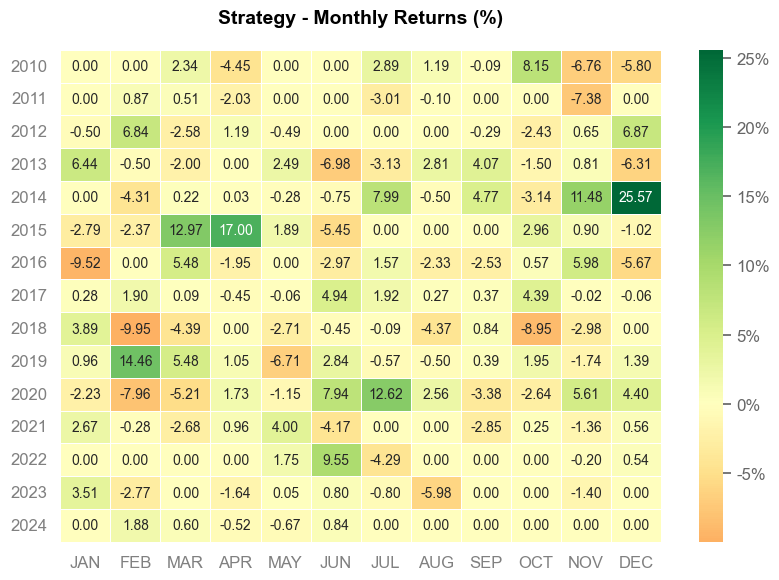

In [19]:
qs.reports.basic(returns)